# Introduction

In this notebook, we analyse a sample of multiome PBMC data. Here, we cover the initial filtering and quality control.

## Load packages

In [1]:
import scanpy as sc
import muon as mu
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

import os 

#pretty plotting
import seaborn as sns

# Import a module with ATAC-seq-related functions
from muon import atac as ac

In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.4.0
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.5
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           1.2.0
h5py                3.7.0
hypergeom_ufunc     NA
igraph              0.10.3
invgauss_ufunc      NA
ipykernel           6.20.2
ipython_genutils    0.2.0
ipywidgets          8.0.4
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.39.1
louvain             0.8.0
matplotlib          3.6.2
mpl_toolkits        NA
mudata              0.2.1
muon                0.1.2
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
nct_ufunc           NA
ncx2_ufunc      

Of note, you can set the context as well to 'talk' or 'paper' in all `seaborn` plots.

In [3]:
sns.set_context(context='paper')

# Set project file paths

We set up the file paths to the respective directories.

In [4]:
file_path = '/home/marenbuettner/data_analysis/muon_tutorial/' 
#this is my file path please adapt it to your directory

File path to the raw data. They are usually stored at a different location than the rest of the project.

In [5]:
data_raw_dir = file_path + 'raw_data/'

The data directory contains all processed data and `mdata` files. 

In [6]:
data_dir = file_path + 'data/' 

The tables directory contains all tabular data output, e.g. in `.csv` or `.xls` file format. That applies to differential expression test results or overview tables such as the number of cells per cell type.

In [7]:
table_dir = file_path + 'tables/'

The resources directory contains any external data input that we use for the project. For instance, gene lists like the cell cycle genes or any manually curated gene list provided by a collaborator can be stored here.

In [8]:
resource_dir = file_path + 'resources/'

The default figure path is a POSIX path calles 'figures'. If you don't change the default figure directory, scanpy creates a subdirectory where this notebook is located.  

In [9]:
sc.settings.figdir = file_path + 'figures/'

**Comment:** When you repeat certain analyses, it might be helpful to set a date variable and add it to every figure and table (see `datetime` Python package).

In [10]:
import datetime

today = datetime.date.today().strftime('%y%m%d') #creates a YYMMDD string of today's date

# Read data

The data is available from [10X Genomics](https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_granulocyte_sorted_10k).

For the tutorial, we will use the following files:

1. Filtered feature barcode matrix (HDF5)

2. ATAC peak annotations based on proximal genes (TSV)

3. ATAC Per fragment information file (TSV.GZ)

4. ATAC Per fragment information index (TSV.GZ index)

In [11]:
# Remove file prefixes if any
prefix = "pbmc_granulocyte_sorted_10k_"
for file in os.listdir(data_raw_dir):
    if file.startswith(prefix):
        new_filename = file[len(prefix):]
        os.rename(os.path.join(data_raw_dir, file), 
        os.path.join(data_raw_dir, new_filename))

We will use an HDF5 file containing gene and peak counts as input. In addition to that, when loading this data, `muon` will look for default files like `atac_peak_annotation.tsv` and `atac_fragments.tsv.gz` in the same folder and will load peak annotation table and remember the path to the fragments file if they exist.

In [12]:
mdata = mu.read_10x_h5(filename=os.path.join(data_raw_dir,
                                'filtered_feature_bc_matrix.h5'))

reading /home/marenbuettner/data_analysis/muon_tutorial/raw_data/filtered_feature_bc_matrix.h5
 (0:00:05)


/home/marenbuettner/miniconda3/envs/muon/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /home/marenbuettner/data_analysis/muon_tutorial/raw_data/filtered_feature_bc_matrix.h5


/home/marenbuettner/miniconda3/envs/muon/lib/python3.8/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from /home/marenbuettner/data_analysis/muon_tutorial/raw_data/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /home/marenbuettner/data_analysis/muon_tutorial/raw_data/atac_fragments.tsv.gz


Let us check the summary of the data. 

In [13]:
mdata.var_names_make_unique()
mdata

MuData object with n_obs × n_vars = 11909 × 144978
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	11909 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

# Quality control

## RNA


Select the gene expression modality from the `MuData` object. Please note that `.copy()` will create a separate object independent of the original `MuData` object, so mapping back will be more difficult.

In [14]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 11909 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

Perform some quality control. For now, we will filter out cells that do not pass QC.

We further aim to determine the fraction of mitochondrial counts per cell.
Please note that mitochondrial genes in human start with 'MT-'. We annotate the group of mitochondrial genes as 'mt' and pass this information to the `sc.pp.calculate_qc_metrics` function. Of note, we can compute the fraction of ribosomal genes in a similar fashion. 

In [15]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata = rna, qc_vars=['mt'],
                            percent_top=None, log1p=False, inplace=True)

Let us visualize the number of expressed genes and the number of counts as a scatter plot. 

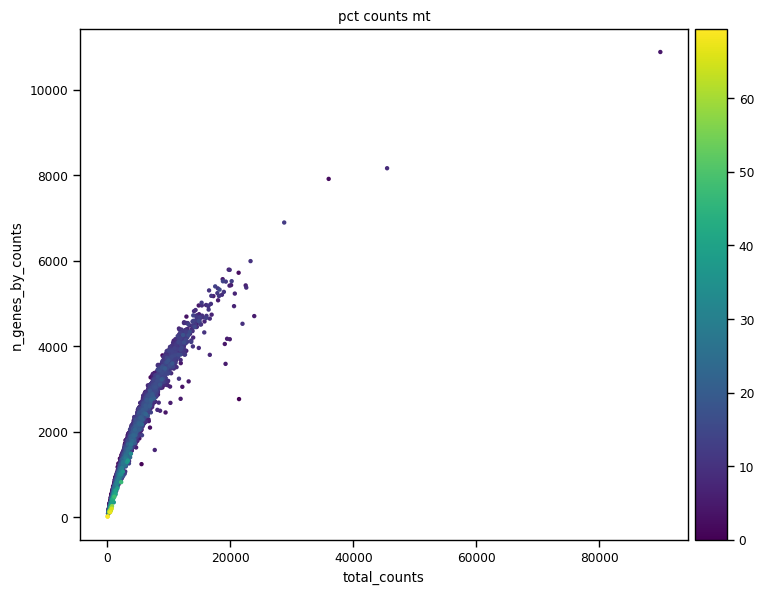

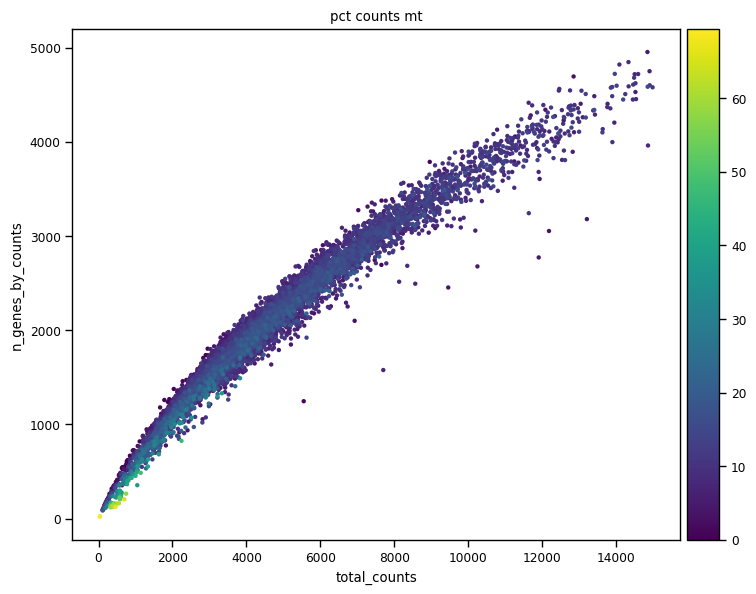

In [16]:
#Data quality summary plots
rcParams['figure.figsize']=(7,7)
p1 = sc.pl.scatter(adata = rna, 
                   x ='total_counts', 
                   y = 'n_genes_by_counts', 
                   color='pct_counts_mt', 
                   size=40)
p2 = sc.pl.scatter(adata = rna[rna.obs['total_counts']<15000], 
                   x = 'total_counts', 
                   y = 'n_genes_by_counts', 
                   color='pct_counts_mt', 
                   size=40)

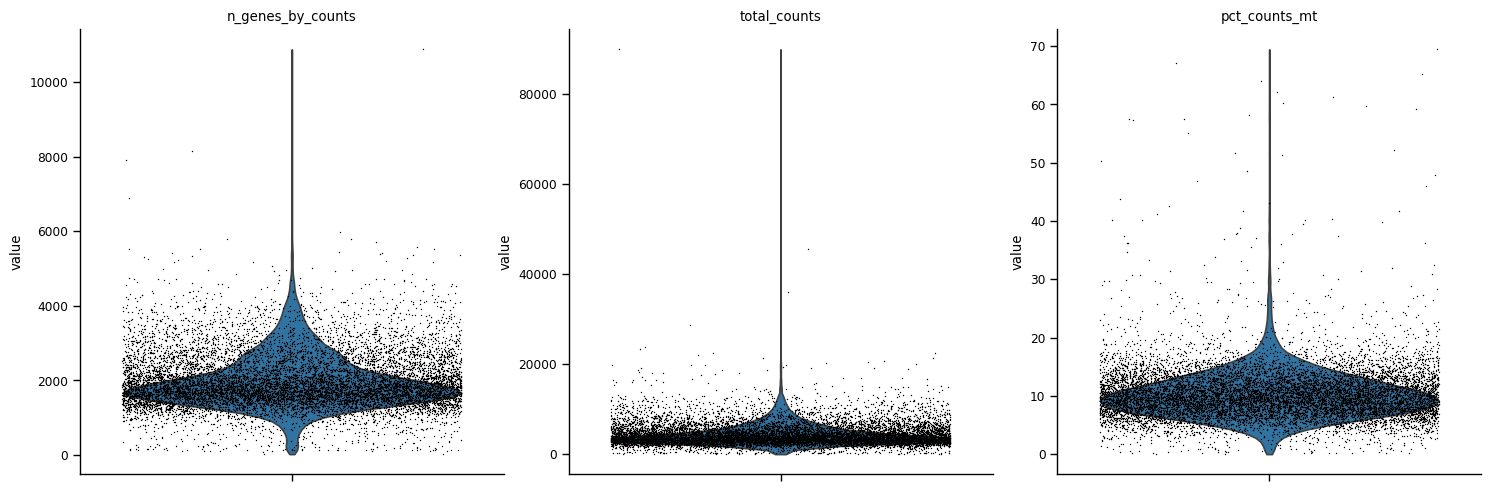

In [17]:
#Sample quality plots
sc.pl.violin(adata=rna, 
             keys = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Next, filter out non-expressed genes. Check the number of remaining genes after filtering.

In [18]:
#Filter genes:
print('Total number of genes: {:d}'.format(rna.n_vars))

# Min 3 cells - filters out 0 count genes
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)

Total number of genes: 36601


Filter your cells according for the total number of counts, number of expressed genes and fraction of mitochondrial reads. Check the number of remaining cells after each filtering step.

In [19]:
# Filter cells according to identified QC thresholds:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# This is analogous to
#   sc.pp.filter_cells(rna, min_genes=200)
#   rna = rna[rna.obs.n_genes_by_counts < 5000, :]
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

### Visualise data post QC

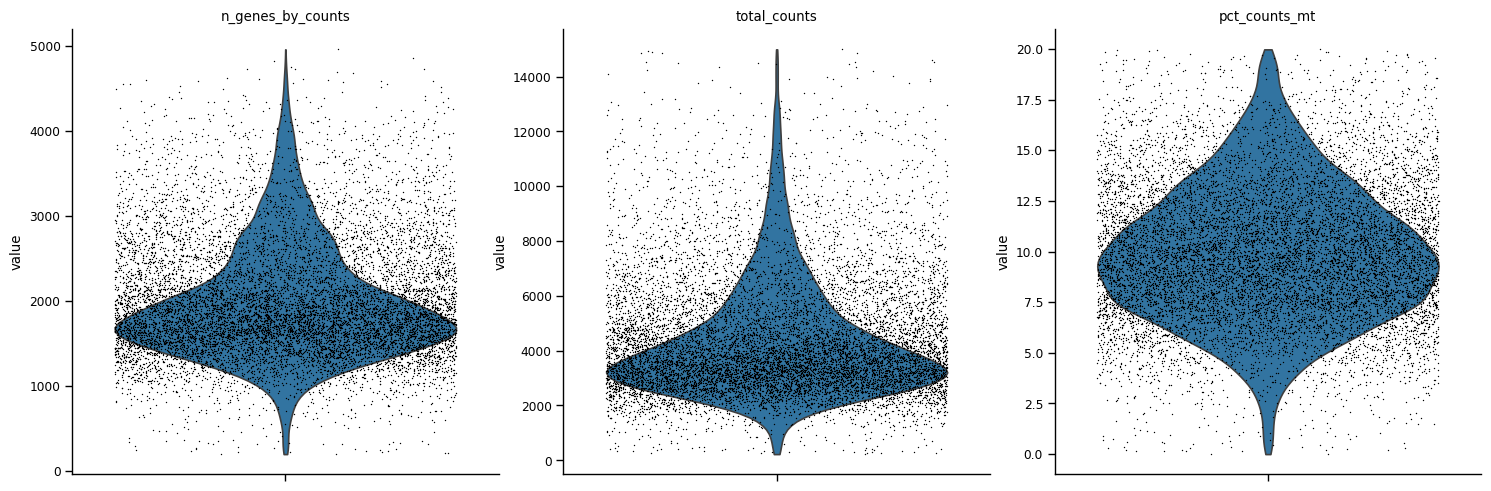

In [20]:
sc.pl.violin(adata = rna, 
             keys = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

## ATAC

Select the ATAC modality from the `MuData` object. To filter, we are going to use the same scanpy functionality as we use when working with gene expression. The only thing to bear in mind here that a `gene` would mean a `peak` in the context of the AnnData object with ATAC-seq data.

In [21]:
atac = mdata.mod['atac']
atac

AnnData object with n_obs × n_vars = 11909 × 108377
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

Perform some quality control filtering out cells with too few peaks and peaks detected in too few cells. For now, we will filter out cells that do not pass QC.

In [22]:
sc.pp.calculate_qc_metrics(adata = atac,
                           percent_top=None, log1p=False, inplace=True)

Let us visualize the number of expressed genes and the number of counts as a scatter plot. 

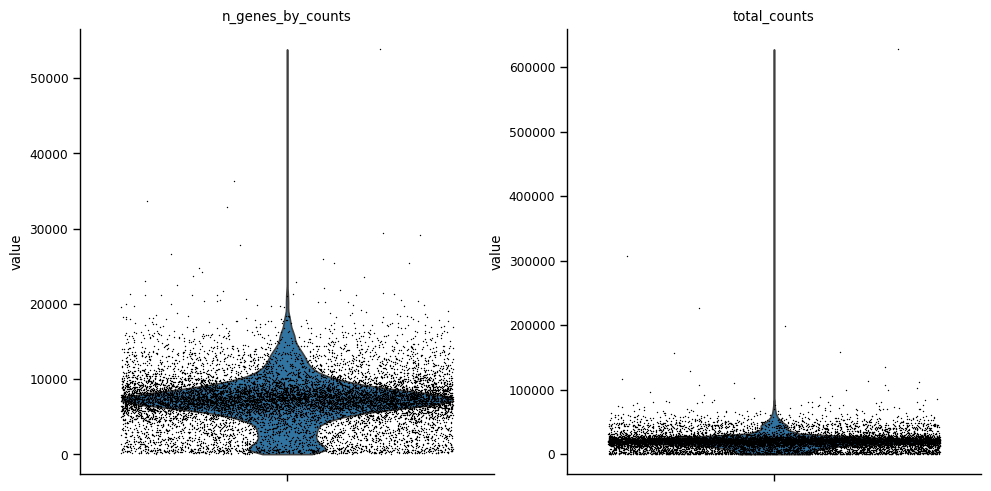

In [23]:
#Sample quality plots
sc.pl.violin(adata=atac, 
             keys = ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

Filter peaks which expression is not detected:

In [24]:
#Filter genes:
print('Total number of genes: {:d}'.format(atac.n_vars))

# Min 10 cells - filters out 0 count genes
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=10)
# but does in-place filtering and avoids copying the object

Total number of genes: 108377


Filter cells:

In [25]:
# Filter cells according to identified QC thresholds:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

### Visualise data filtering

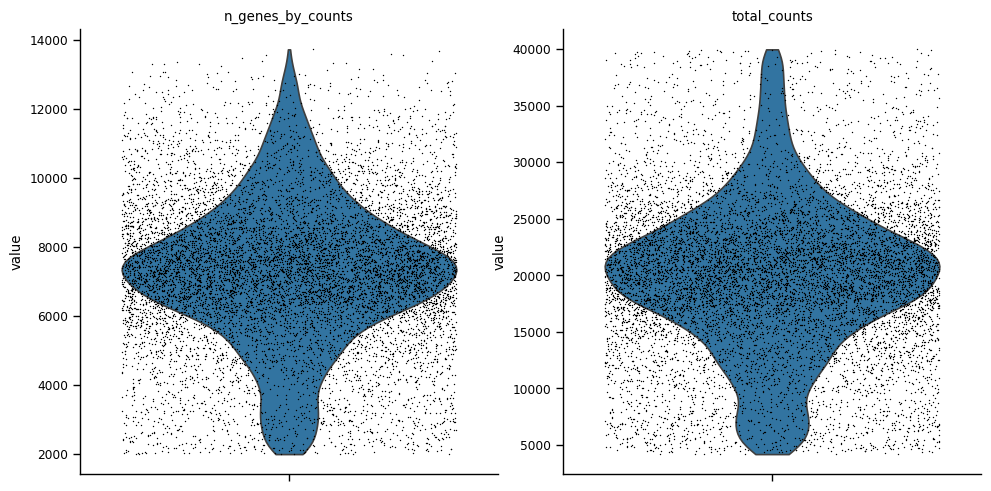

In [27]:
sc.pl.violin(adata = atac, 
             keys = ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

Or as a histogram:

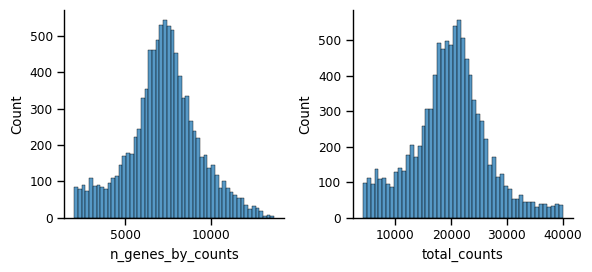

In [28]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'])

### ATAC-specific QC

There are a few expectations about how ATAC-seq data looks like as noted in the [hitchhiker’s guide to ATAC-seq data analysis](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1929-3#citeas) for instance.

#### Nucleosome positioning

Fragment size distribution typically reflects nucleosome binding pattern showing enrichment around values corresponding to fragments bound to a single nucleosome (between 147 bp and 294 bp) as well as nucleosome-free fragments (shorter than 147 bp).

In [29]:
#initialise obs
atac.obs['NS']=1

Fetching Regions...: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


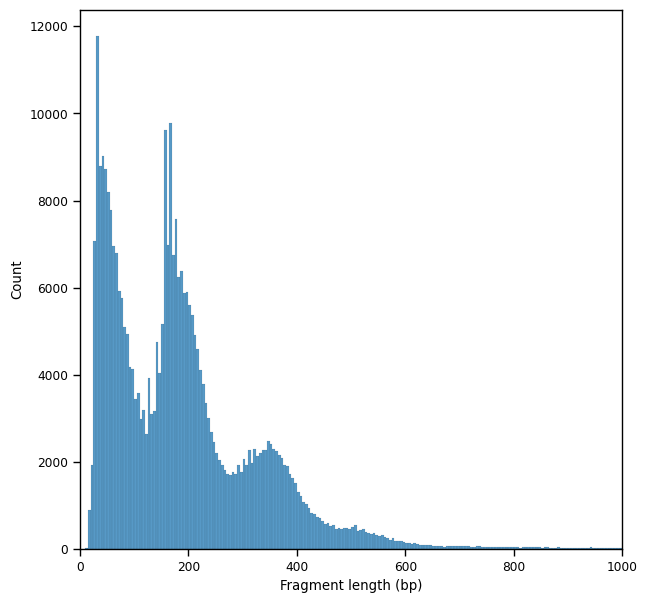

In [30]:
ac.pl.fragment_histogram(atac, region='chr1:1-2000000')

The ratio of mono-nucleosome cut fragments to nucleosome-free fragments can be called **nucleosome signal**, and it can be estimated using a subset of fragments.

In [31]:
ac.tl.nucleosome_signal(atac, n=1e6)

Reading Fragments: 100%|██████████| 1000000/1000000 [00:02<00:00, 344295.74it/s]

Added a "nucleosome_signal" column to the .obs slot of the AnnData object


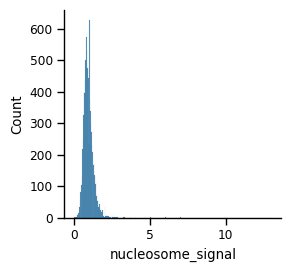

In [32]:
mu.pl.histogram(atac, "nucleosome_signal", kde=False)

### TSS enrichment

We can expect chromatin accessibility enriched around transcription start sites (TSS) compared to accessibility of flanking regions. Thus this measure averaged across multiple genes can serve as one more quality control metric.

The positions of transcription start sites can be obtained from the interval field of the gene annotation in the `rna` modality:

In [33]:
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(3)  
# accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

,Chromosome,Start,End,gene_id,gene_name
AL627309.1,chr1,120931,133723,ENSG00000238009,AL627309.1
AL627309.5,chr1,149706,173862,ENSG00000241860,AL627309.5
AL627309.4,chr1,160445,160446,ENSG00000241599,AL627309.4


TSS enrichment function will return an AnnData object with `cells x bases` dimensions where `base`s correspond to positions around TSS and are defined by `extend_upstream` and `extend_downstream` parameters, each of them being 1000 bp by default. It will also record `tss_score` in the original object.

In [34]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  
# by default, features=ac.tl.get_gene_annotation_from_rna(mdata)

Fetching Regions...: 100%|██████████| 1000/1000 [00:15<00:00, 63.73it/s]

Added a "tss_score" column to the .obs slot of tof the 'atac' modality


In [35]:
tss

AnnData object with n_obs × n_vars = 10069 × 2001
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

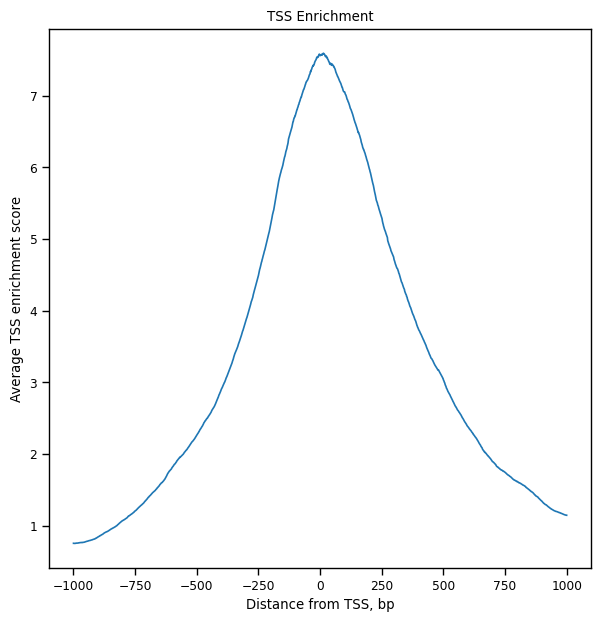

In [36]:
ac.pl.tss_enrichment(tss)

# Save filtered data to file

Troubleshooting: `scanpy/anndata` does not support writing `OrderedDict` to file. So we convert all `OrderedDict` to `dict()` to circumvent the problem.

In [48]:
from collections import OrderedDict

In [50]:
for key in mdata['atac'].uns_keys():
    if isinstance(mdata['atac'].uns[key], OrderedDict):
        mdata['atac'].uns[key] = dict(mdata['atac'].uns[key])


In [51]:
mdata.write(data_dir + 'mdata_postQC.h5mu')